In [1]:
import os
import numpy as np
import pandas as pd

from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_exact
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D


In [2]:
# Function to process the FITS files
def read_fits_files(filepath, hdu_idx):
    # Get a list of all FITS files in the input directory
    # Open the FITS file
    hdu = fits.open(filepath, memmap=False)[hdu_idx]
    return hdu

def pad_image_with_nans(image, pad_width):
    # Create an array filled with NaNs with the new shape
    padded_shape = (image.shape[0] + 2 * pad_width, image.shape[1] + 2 * pad_width)
    padded_image = np.full(padded_shape, np.nan)
    
    # Insert the original image into the center of the padded array
    padded_image[pad_width:pad_width + image.shape[0], pad_width:pad_width + image.shape[1]] = image
    
    return padded_image


In [3]:
filepaths = ["/mnt/g/data/PhD Projects/SR/obs_datamaps/mips_24_GO3_sci_10_interp_bkg_subtracted.fits",
            "/mnt/g/data/PhD Projects/SR/obs_datamaps/COSMOS-Nest_image_500_SMAP_v6.0_interp_bkg_subtracted.fits",
            "/mnt/g/data/PhD Projects/SR/obs_datamaps/SCS_450_corr.fits"]

hdu_idx = [0, 1, 0]

In [4]:
hdus = [read_fits_files(file, hdu_idx[idx]) for idx, file in enumerate(filepaths)]

In [5]:
hdus[1].data.shape

(856, 823)

Set MJD-END to 55733.595211 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 55733.595211 from DATE-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    19.822853 from OBSGEO-[XYZ].
Set OBSGEO-H to     4120.022 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


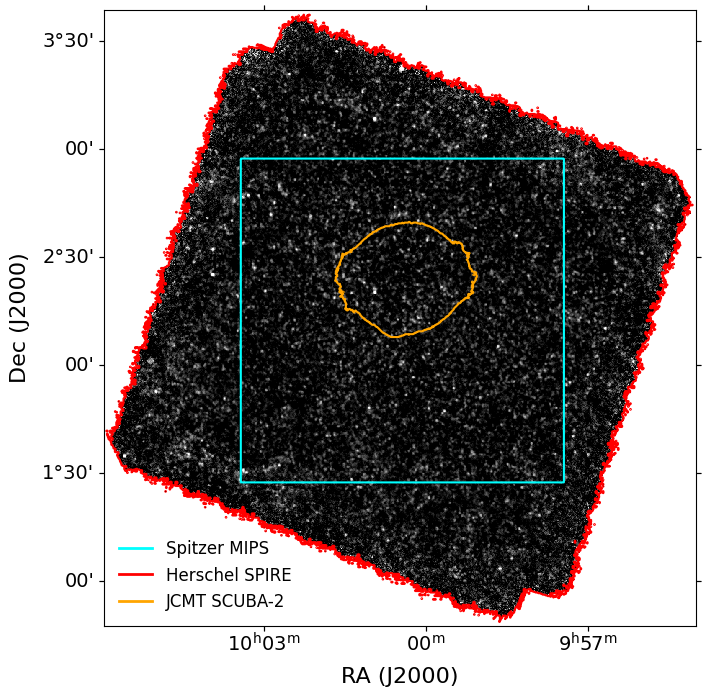

In [7]:
def pad_image_with_nans(image, pad_width):
    # Create an array filled with NaNs with the new shape
    padded_shape = (image.shape[0] + 2 * pad_width, image.shape[1] + 2 * pad_width)
    padded_image = np.full(padded_shape, np.nan)
    
    # Insert the original image into the center of the padded array
    padded_image[pad_width:pad_width + image.shape[0], pad_width:pad_width + image.shape[1]] = image
    
    return padded_image

# Create a WCS projection from the header of the primary HDU
wcs_projection = WCS(hdus[1].header)

# Create a figure with WCS projection for the main image
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection=wcs_projection)
ax.set_ylabel("Dec (J2000)", fontsize=16)
ax.set_xlabel("RA (J2000)", fontsize=16)
ax.tick_params(axis='both', labelsize=14)

colors = ['cyan', "red", "orange"]

for idx, hdu in enumerate(hdus):
    # Reproject the image to the WCS projection
    reproj_map, footprint = reproject_exact(hdu, wcs_projection)
      
    # Create a binary mask to show contours for the extent of the data
    binary_mask = np.where(np.isnan(reproj_map), 0, 1)
    ax.contour(binary_mask, levels=[0.5], colors=colors[idx])  # Contour for the extent
    
    # If idx == 1, display the image with specific settings
    if idx == 1:
        ax.imshow(reproj_map, origin='lower', cmap='gray', interpolation='none', vmin=1e-3, vmax=50e-3)  # Display the data
    
# Create custom legend handles
legend_elements = [Line2D([0], [0], color=color, lw=2, label=label) 
                   for color, label in zip(colors, ["Spitzer MIPS", "Herschel SPIRE", "JCMT SCUBA-2"])]

# Add the legend to the plot
ax.legend(handles=legend_elements, loc="lower left", frameon=False, fontsize=12)

plt.savefig("spitzer_spire_scuba_contours.pdf", bbox_inches='tight', dpi=300, transparent=True)
plt.show()